In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, LayerNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
!pwd
!ls

/content
sample_data


In [3]:
# Laste poll-of-polls data
#df = pd.read_csv("../data/all_polls.csv", sep=",", encoding='ISO-8859-1')
#df= pd.read_csv("https://github.com/jensmorten/onesixtynine/blob/JM/data/all_polls.csv", sep=",", encoding='ISO-8859-1')
df = pd.read_csv("https://raw.githubusercontent.com/jensmorten/onesixtynine/JM/data/all_polls.csv", sep=",", encoding='ISO-8859-1')

In [4]:
# Convert to datetime and set the date to the end of the month
df["Dato"] = pd.to_datetime(df["Dato"])

In [5]:
# Sort values and set index
df = df.sort_values("Dato")
df.set_index("Dato", inplace=True)

In [6]:
df_en=df[["Ap","Høyre","Frp","SV","Sp","KrF","Venstre","MDG","Rødt", "Andre"]]

In [7]:
df

,Måling,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre,Year,Month
Dato,,,,,,,,,,,,,
2008-01-09,Verian/TV2,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0,2008,1
2008-01-10,Sentio/BT,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0,2008,1
2008-01-18,Norstat/NRK,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0,2008,1
2008-01-21,InFact/VG,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0,2008,1
2008-01-21,Respons/Aftenp,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0,2008,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-05,Verian/TV2,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8,2025,9
2025-09-05,Norstat/NRK / VL / Dagbl.,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1,2025,9
2025-09-06,Norfakta/Nat. / KK,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9,2025,9


In [8]:
df_en.head(20)

,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
Dato,,,,,,,,,,
2008-01-09,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
2008-01-10,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-18,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
2008-01-21,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0
2008-01-21,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0
2008-01-24,26.1,17.5,25.4,7.9,6.3,6.0,6.4,0.0,3.2,0.0
2008-01-24,28.0,14.6,24.0,7.1,6.0,7.1,9.5,0.0,2.0,0.0
2008-01-30,28.0,18.8,20.6,10.1,8.0,5.5,6.0,0.0,2.4,0.0
2008-02-02,30.3,16.9,26.0,6.1,5.3,6.2,6.7,0.0,1.2,0.0


In [9]:
df_test=df_en
df_test=df_test.reset_index()

In [10]:
df_test

,Dato,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
0,2008-01-09,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
1,2008-01-10,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2,2008-01-18,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
3,2008-01-21,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0
4,2008-01-21,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1858,2025-09-05,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8
1859,2025-09-05,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1
1860,2025-09-06,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9
1861,2025-09-06,27.3,14.9,21.3,5.7,6.0,4.7,3.9,6.4,5.3,4.7


In [11]:
df_test["rank"] = df_test.groupby(df_test["Dato"].dt.date).cumcount()

In [12]:
times = pd.to_timedelta([0, 4, 8, 12, 16, 18, 22], unit="h")
df_test["DateTime"] = df_test["Dato"].dt.normalize() + df_test["rank"].map(dict(zip(range(7), times)))

In [13]:
df_test

,Dato,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre,rank,DateTime
0,2008-01-09,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0,0,2008-01-09 00:00:00
1,2008-01-10,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0,0,2008-01-10 00:00:00
2,2008-01-18,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0,0,2008-01-18 00:00:00
3,2008-01-21,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0,0,2008-01-21 00:00:00
4,2008-01-21,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0,1,2008-01-21 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,2025-09-05,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8,0,2025-09-05 00:00:00
1859,2025-09-05,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1,1,2025-09-05 04:00:00
1860,2025-09-06,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9,0,2025-09-06 00:00:00
1861,2025-09-06,27.3,14.9,21.3,5.7,6.0,4.7,3.9,6.4,5.3,4.7,1,2025-09-06 04:00:00


In [14]:
df_test= df_test.drop(columns=["Dato", "rank"]).set_index("DateTime").sort_index()

In [15]:
df_test

,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
DateTime,,,,,,,,,,
2008-01-09 00:00:00,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
2008-01-10 00:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-18 00:00:00,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
2008-01-21 00:00:00,28.4,20.6,24.7,5.6,6.1,6.7,5.2,0.0,1.6,0.0
2008-01-21 04:00:00,30.7,18.3,24.2,7.1,5.4,6.2,5.4,0.0,1.1,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-09-05 00:00:00,27.7,15.0,21.0,5.8,5.8,4.2,3.9,6.4,5.3,4.8
2025-09-05 04:00:00,26.4,14.3,20.4,6.0,6.2,4.2,4.3,7.2,6.9,4.1
2025-09-06 00:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9


In [16]:
full_idx = pd.date_range(df_test.index.min(), df_test.index.max(), freq="6h")
df_test = df_test.reindex(full_idx).bfill()

In [17]:
df_test

,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
2008-01-09 00:00:00,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
2008-01-09 06:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-09 12:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-09 18:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-10 00:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-09-05 06:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9
2025-09-05 12:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9
2025-09-05 18:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9
2025-09-06 00:00:00,27.0,13.5,20.8,5.3,7.0,5.8,4.1,6.0,5.6,4.9


In [18]:
#df_fixed = expand_and_impute(df_en, resample_freq="6H")
df_fixed=df_test.dropna()
# Quick check
print("Any NaNs left?", df_fixed.isna().sum().sum())
print("Row sums sample:", df_fixed.sum(axis=1).head(10).values)

Any NaNs left? 0
Row sums sample: [97.3 96.8 96.8 96.8 96.8 96.7 96.7 96.7 96.7 96.7]


In [19]:
df_en=df_fixed

In [20]:
df_en.head(50)

,Ap,Høyre,Frp,SV,Sp,KrF,Venstre,MDG,Rødt,Andre
2008-01-09 00:00:00,32.7,14.1,23.2,7.1,6.4,7.8,6.0,0.0,0.0,0.0
2008-01-09 06:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-09 12:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-09 18:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-10 00:00:00,30.7,16.2,23.4,8.1,5.4,5.6,7.4,0.0,0.0,0.0
2008-01-10 06:00:00,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
2008-01-10 12:00:00,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
2008-01-10 18:00:00,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
2008-01-11 00:00:00,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0
2008-01-11 06:00:00,29.5,17.7,25.6,6.4,5.0,6.4,6.1,0.0,0.0,0.0


In [21]:
#n_timesteps = 5   # past steps to look at
#n_future = 12      # steps into the future we want to predict
n_features = df_en.shape[1]
series_names = df_en.columns
window_size=10*4

In [22]:
def windowed_dataset_multivariate(series, window_size, batch_size, shuffle_buffer):
    """
    Creates a tf.data.Dataset for multivariate time series.

    series: numpy array or tf.Tensor with shape (num_timesteps, num_features)
    window_size: number of timesteps in the input window
    batch_size: training batch size
    shuffle_buffer: buffer size for shuffling
    """
    # Make a Dataset of timesteps
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Create sliding windows of length (window_size + 1)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Convert each window into a batch tensor
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Shuffle windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Split into (input, label):
    # inputs = first window_size steps, labels = last step
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [23]:
#split = int(len(X) * 0.90)
#X_train, X_test = X[:split], X[split:]
#y_train, y_test = y[:split], y[split:]

In [34]:
window_size = 21*6
batch_size = 500
shuffle_buffer = 100

split = int(len(df_en) * 0.90)
train_data = df_en.values[:split]
val_data   = df_en.values[split:]

train_dataset = windowed_dataset_multivariate(train_data, window_size, batch_size, shuffle_buffer=shuffle_buffer)
val_dataset   = windowed_dataset_multivariate(val_data,   window_size, batch_size, shuffle_buffer=1)


In [35]:
y_values = []
for _, y in train_dataset:
    y_values.append(y.numpy())

y_all = np.concatenate(y_values, axis=0)  # shape: (num_train, num_features)

# Compute column weights (inverse of std)
col_stds = np.std(y_all, axis=0)
power = 2  # increase emphasis on small parties
col_weights = (1.0 / (col_stds + 1e-6)) ** power
##col_weights = 1.0 / (col_stds + 1e-6)  # avoid divide-by-zero
col_weights = col_weights / np.mean(col_weights)  # normalize to mean 1

print("Column weights:", col_weights)

Column weights: [0.09581991 0.13984368 0.11171506 0.90479793 0.17005933 2.80639417
 2.77087594 0.83210696 0.75966885 1.40871817]


In [36]:
col_weights_tf = tf.constant(col_weights, dtype=tf.float32)

def weighted_mse(y_true, y_pred):
    squared_error = tf.square(y_true - y_pred)
    weighted_error = squared_error * col_weights_tf  # broadcast along features
    return tf.reduce_mean(weighted_error)

In [37]:
n_features = 10
model = Sequential([
    tf.keras.layers.Input(shape=(window_size, n_features)),
    tf.keras.layers.Conv1D(filters=10, kernel_size=window_size,
                      strides=int(np.floor(window_size/(10))),
                      activation="relu",
                      padding='causal'),
    tf.keras.layers.LSTM(200, return_sequences=True),
    tf.keras.layers.Dropout(0.2),  # 20% dropout after first LSTM
    tf.keras.layers.LSTM(10, return_sequences=False),
    tf.keras.layers.Dropout(0.2),  # 20% dropout after second LSTM
    tf.keras.layers.Dense(50),
    tf.keras.layers.Dense(n_features),
    tf.keras.layers.Lambda(lambda x: tf.nn.softmax(x) * 100)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=weighted_mse,  # or "mae" if you prefer absolute error
    metrics=["mae"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 11, 10)         │        12,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 11, 200)        │       168,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10)             │         8,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │           550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,910 (745.74 KB)

 Trainable params: 190,910 (745.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1,
        min_lr=1e-7
    )
]


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks
)


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - loss: 51.3696 - mae: 9.3787 - val_loss: 32.1981 - val_mae: 7.3952 - learning_rate: 1.0000e-05
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - loss: 48.7182 - mae: 9.4391 - val_loss: 30.1780 - val_mae: 7.3762 - learning_rate: 1.0000e-05
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - loss: 46.4255 - mae: 9.3814 - val_loss: 27.9000 - val_mae: 7.2501 - learning_rate: 1.0000e-05
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 43.7645 - mae: 9.1912 - val_loss: 25.7536 - val_mae: 7.0413 - learning_rate: 1.0000e-05
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 41.4546 - mae: 8.9821 - val_loss: 23.9941 - val_mae: 6.8417 - learning_rate: 1.0000e-05
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 39.5191 - mae: 8.8023 - val_loss: 22.5354 - val_mae: 6.6770 - learning_rate: 1.0000e-05
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - loss: 37.8104 - mae: 8.6501 - val_loss: 21.1911 

In [ ]:
# --- 1) Collect validation data into arrays ---
X_test, y_test = [], []
for X_batch, y_batch in val_dataset:
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print("X_test shape:", X_test.shape)  # (num_test, window_size, 10)
print("y_test shape:", y_test.shape)  # (num_test, 10)

77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step


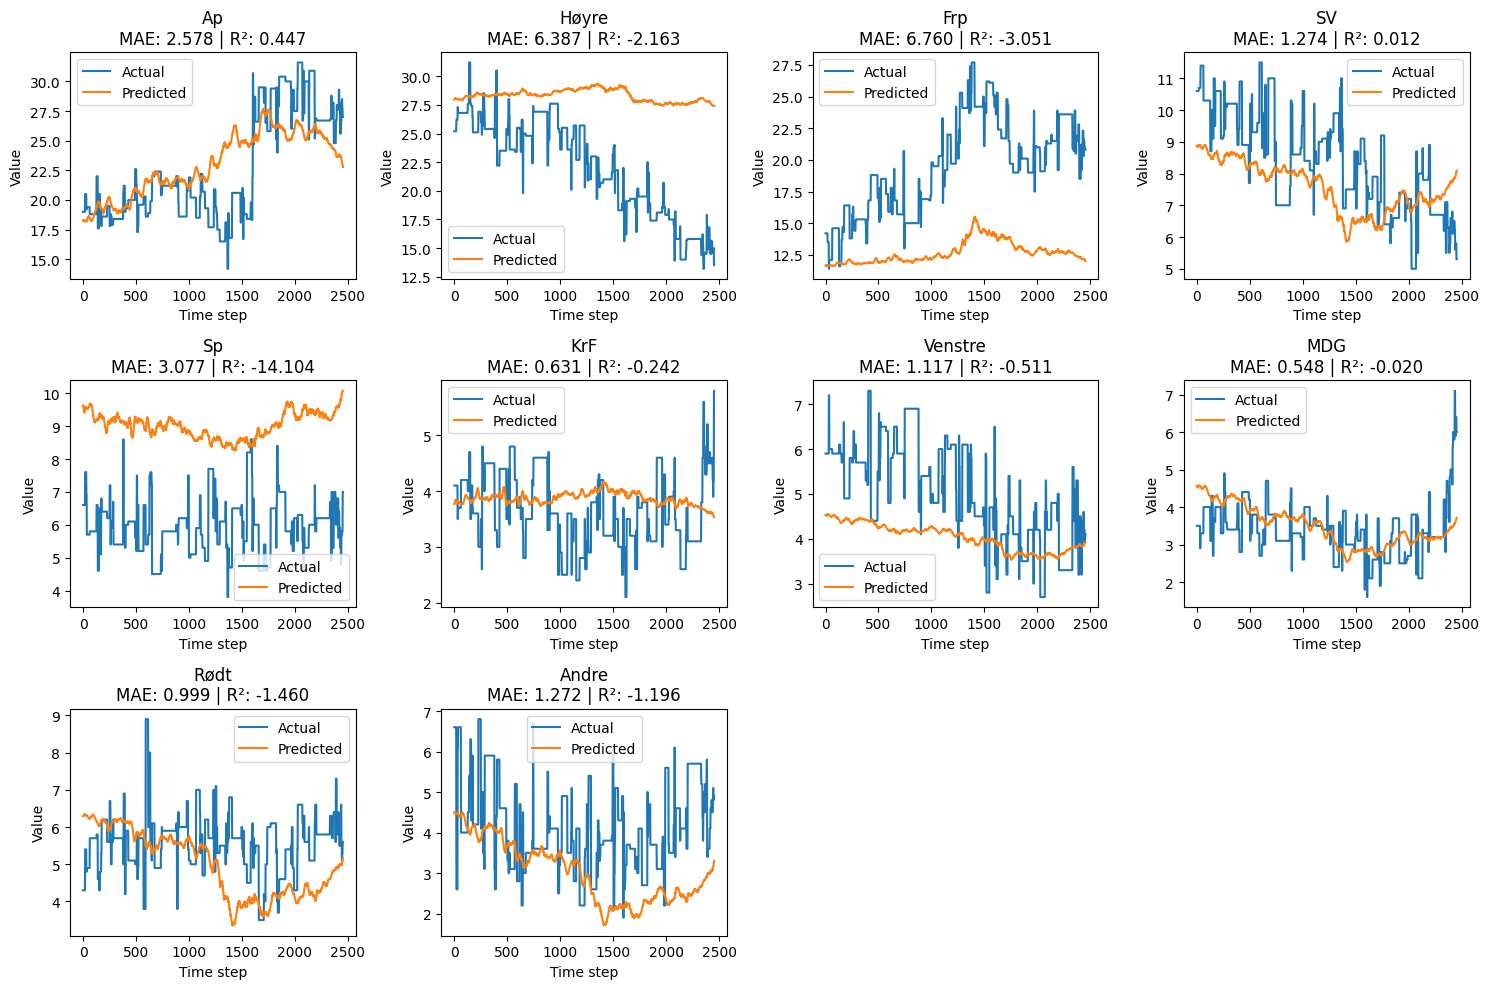

In [33]:
y_pred = model.predict(X_test)  # shape: (num_test, 9)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, col in enumerate(df_en.columns):
    mae = np.mean(np.abs(y_test[:, i] - y_pred[:, i]))
    # Compute R² (fixed parentheses)
    ss_res = np.sum((y_test[:, i] - y_pred[:, i]) ** 2)
    ss_tot = np.sum((y_test[:, i] - np.mean(y_test[:, i])) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    plt.subplot(3, 4, i+1)
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f"{col}\nMAE: {mae:.3f} | R²: {r2:.3f}")
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
np.sum(y_test, axis=1)